# Lab 02: Credit Ratings

---
author: Jakub Szumny
date: September 13, 2024
embed-resources: true
---

## Introduction

Credit ratings are evaluations of risk associated with loaning money or extending credit. As an analysist for a small local bank, our bank has relied on the credit agencies to provide our customers' credit ratings, but this costs money. My goal is to reverse engineer customers' credit rating based on their credit ratings, their income and demographic information such as age and education level, and to use it to create a regression model that predicts an individual's credit rating.

## Methods

In [16]:
# imports
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import make_scorer

### Data

In [17]:
# load data
credit_train = pd.read_csv("https://cs307.org/lab-02/data/credit-train.csv")
credit_test = pd.read_csv("https://cs307.org/lab-02/data/credit-test.csv")

In [18]:
credit_train

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
0,257.0,44.473,81.0,16.0,Female,No,No,NaN
1,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
2,388.0,16.479,26.0,16.0,Male,NaN,No,NaN
3,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
4,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian
...,...,...,...,...,...,...,...,...
251,268.0,26.370,78.0,11.0,Male,No,Yes,Asian
252,433.0,26.427,50.0,15.0,Female,Yes,Yes,Asian
253,259.0,12.031,58.0,18.0,Female,NaN,Yes,Caucasian
254,335.0,80.861,29.0,15.0,Female,No,Yes,Asian


The data is from a historical credit data set which has been provided to me, and its original source is from the textbook "An Introduction to Statistical Learning", which simulated this data. The data includes a response which is "rating", and seven features: "Income", which is yearly income; "Age"; "Education", which is years of education completed; "Gender"; "Student", which is a yes/no variable; "Married", which is a yes or no variable; and "Ethinicity".

In [19]:
# summary statistics
print("# of Samples", len(credit_train))
print("# of Features", len(credit_train.columns) - 1 )
print()
print("Rating Mean", credit_train["Rating"].mean())
print("Rating STD", credit_train["Rating"].std())
print()
print("Not Students Mean", credit_train[credit_train["Student"] == "No"]["Rating"].mean())
print("Not Students STD", credit_train[credit_train["Student"] == "No"]["Rating"].std())
print("Not Students Count", len(credit_train[credit_train["Student"] == "No"]["Rating"]))
print("Are Students Mean", credit_train[credit_train["Student"] == "Yes"]["Rating"].mean())
print("Are Students STD", credit_train[credit_train["Student"] == "Yes"]["Rating"].std())
print("Are Students Count", len(credit_train[credit_train["Student"] == "Yes"]["Rating"]))

# of Samples 256
# of Features 7

Rating Mean 347.609375
Rating STD 148.8931046679028

Not Students Mean 349.51173708920186
Not Students STD 148.00352527445554
Not Students Count 213
Are Students Mean 338.4736842105263
Are Students STD 149.1644761183859
Are Students Count 19


In [20]:
print("Not Married Mean", credit_train[credit_train["Married"] == "No"]["Rating"].mean())
print("Not Married STD", credit_train[credit_train["Married"] == "No"]["Rating"].std())
print("Not Married Count", len(credit_train[credit_train["Married"] == "No"]["Rating"]))
print("Are Married Mean", credit_train[credit_train["Married"] == "Yes"]["Rating"].mean())
print("Are Married STD", credit_train[credit_train["Married"] == "Yes"]["Rating"].std())
print("Are Married Count", len(credit_train[credit_train["Married"] == "Yes"]["Rating"]))

Not Married Mean 329.3979591836735
Not Married STD 132.03964882478107
Not Married Count 98
Are Married Mean 358.90506329113924
Are Married STD 157.7979352901777
Are Married Count 158


In [21]:
some = ["Rating", "Age", "Income"]
credit_train[some].corr()

,Rating,Age,Income
Rating,1.000000,0.143032,0.770842
Age,0.143032,1.000000,0.202098
Income,0.770842,0.202098,1.000000


In [22]:
missing = credit_train.isnull().sum()
missing / len(credit_train)


Rating       0.000000
Income       0.000000
Age          0.128906
Education    0.097656
Gender       0.023438
Student      0.093750
Married      0.000000
Ethnicity    0.097656
dtype: float64

<Figure size 1400x800 with 0 Axes>

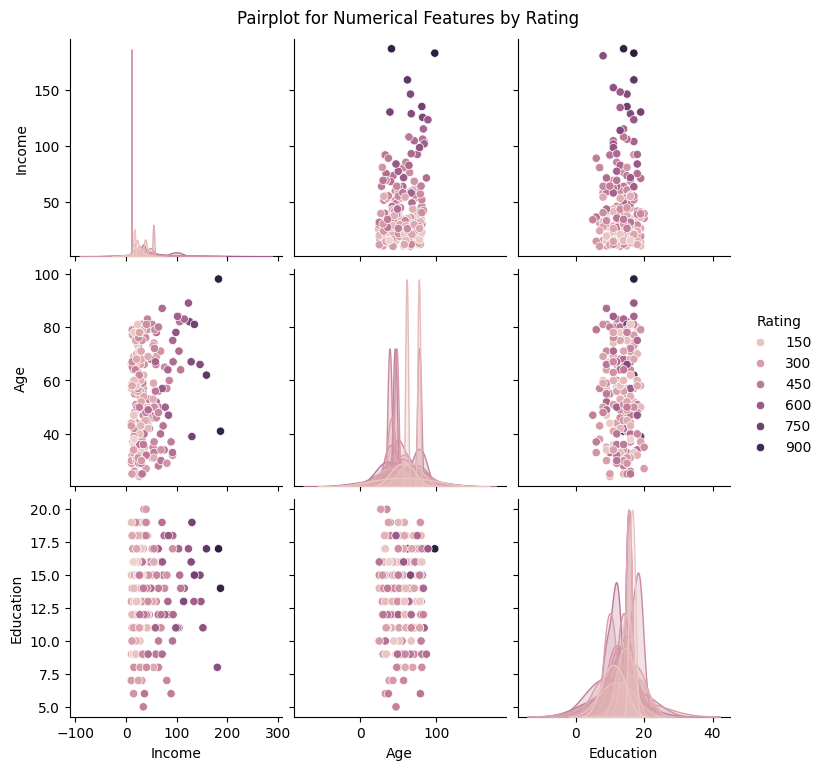

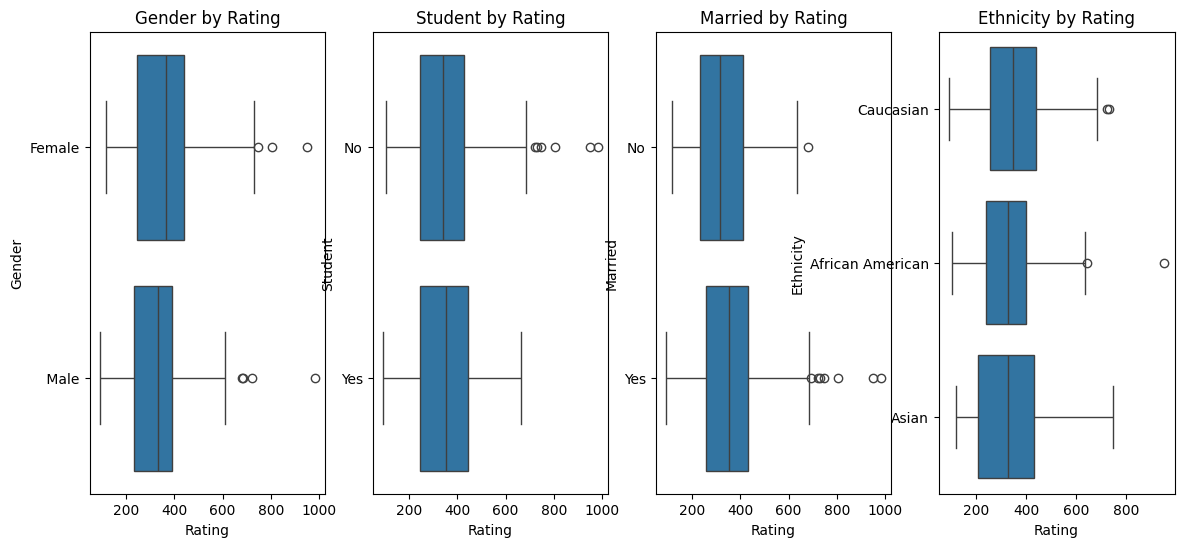

In [23]:
# visualizations

plt.figure(figsize=(14, 8))
numerical_features = ['Income', 'Age', 'Education']
sns.pairplot(credit_train, vars=numerical_features, hue='Rating')
plt.suptitle('Pairplot for Numerical Features by Rating', y=1.02)

plt.figure(figsize=(14, 6))

plt.subplot(1, 4, 1)
sns.boxplot(x='Rating', y='Gender', data=credit_train)
plt.title('Gender by Rating')

plt.subplot(1, 4, 2)
sns.boxplot(x='Rating', y='Student', data=credit_train)
plt.title('Student by Rating')

plt.subplot(1, 4, 3)
sns.boxplot(x='Rating', y='Married', data=credit_train)
plt.title('Married by Rating')

plt.subplot(1, 4, 4)
sns.boxplot(x='Rating', y='Ethnicity', data=credit_train)
plt.title('Ethnicity by Rating')

plt.show()

Based off of the summary statistics and the visualizations, we can see that different features have different correlations with the actual rating of individuals. We see that females tend to have higher ratings, that being a student does not matter as much, that being married has slightly higher ratings, that ethnicities tends to be the same across all. We can see that the more income you have, the higher your rating tends to be, that the older you are it tends to be higher, but sometimes there are outliers, and education varies as well. From all of this we can tell that some features affect the response more than others, but we will still use all of the features in our model.

### Models

In [24]:
# process data for ML
# create X and y for train
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# create X and y for test
X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]
X_train

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

# Drop rows with missing values from X_test and align y_test accordingly
# This step is optional but ensures consistency if your test set also contains missing values
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]


X_train.shape, y_train.shape, X_test.shape, y_test.shape
X_train


,Income,Age,Education,Gender,Student,Married,Ethnicity
3,10.793,29.0,13.0,Male,No,No,Caucasian
4,76.273,65.0,14.0,Female,No,Yes,Caucasian
7,36.355,35.0,9.0,Male,No,Yes,Asian
8,34.664,77.0,15.0,Female,No,Yes,African American
9,128.669,67.0,16.0,Male,No,Yes,Asian
...,...,...,...,...,...,...,...
250,15.629,60.0,14.0,Male,No,Yes,Asian
251,26.370,78.0,11.0,Male,No,Yes,Asian
252,26.427,50.0,15.0,Female,Yes,Yes,Asian
254,80.861,29.0,15.0,Female,No,Yes,Asian


In [30]:

numeric_features = ["Income", "Age", "Education"]
categorical_features = ["Gender", "Student", "Married", "Ethnicity"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", KNeighborsRegressor()),
    ]
)

param_grid = {
    "preprocessor__cat__onehot__drop": [None, "first"],
    "preprocessor__num__scaler": [None, StandardScaler()],
    "regressor__n_neighbors": [3, 5, 7, 9, 11],
    "regressor__metric": ["euclidean", "manhattan"],
}

rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=rmse_scorer)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation RMSE: {grid_search.best_score_}")

y_pred = grid_search.predict(X_test)
print(f"Test set RMSE: {mean_squared_error(y_test, y_pred, squared= False)}")
print(f"Test set R^2: {r2_score(y_test, y_pred)}")

c:\Users\kubas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\kubas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\kubas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\kubas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarnin

Best parameters: {'preprocessor__cat__onehot__drop': 'first', 'preprocessor__num__scaler': None, 'regressor__metric': 'euclidean', 'regressor__n_neighbors': 11}
Best cross-validation RMSE: -103.22873761690023
Test set RMSE: 104.78387619427463
Test set R^2: 0.5568491551359005


c:\Users\kubas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\kubas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\kubas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\kubas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarnin

Here I used a pipeline and a grid search to determine the best parameters of a KNearest Neighbors Regression model. This gave me a cross validations rmse of -103.22, a test set rmse of 104.783, and a test set r^2 of 0.55.

In [26]:
from joblib import dump
best_model = grid_search.best_estimator_
dump(best_model, "credit-ratings.joblib")

['credit-ratings.joblib']

## Results

In [27]:
# report model metrics
print(f"Test set RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"Test set R^2: {r2_score(y_test, y_pred)}")

Test set RMSE: 104.78387619427463
Test set R^2: 0.5568491551359005


c:\Users\kubas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Again, here we can see the model achieved a test set RMSE of 104.78, and a test set R^2 of 0.557.

## Discussion

While a test set RMSE of 104, meets the requirements, and the R^2 is .557, the model is still not perfect. It can definitely predict somewhat accurate credit ratings based off of the features, but it could definitely be improved, by using a different model.

I think that it does seem appropriate to use some of these features for the goal of this model, as they are real things that could alter your credit rating, but some of them don't apply. I don't believe ethinicity or age should be used, as it is actually illegal to purposefully have someones credit rating lower based on ethinicity, and it is also unethical to use that and to use age. These things do not determine whether or not someone has good credit rating, it is more so based off of their past credit history. I believe some more features that would help this model is more of credit history features, and not just basic information that doesn't fully support the model. Seeing as how even in the visualizations a lot of the features didn't even correlate with the rating, they should not be used in the future. I believe that the model did not perform to its best ability because of these features that did not help the model train at all.



### Conclusion

Given the average/subpar performance of the model, along with some legal and ethical issues with the data being used in a model like this, I would not reccomend this model for use in practice at this time. This model definitely could be improved by removing these unecessary and unethical features, and incorporating more valid features such as someones credit history.